# Fitting the 2D Resolution Function to a Gaussian-Ikeda Carpenter Function

 Adding the path of the Ikeda Carpenter library

import the Ikeda Carpenter Function

In [1]:
import sys,os
sys.path.append('/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres')
from dgsres import icg

In [2]:
# this is a input parameter
import res_params_interped_funcs as rpif
reload(rpif)

<module 'res_params_interped_funcs' from 'res_params_interped_funcs.pyc'>

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
import histogram.hdf as hh, histogram as H
import lmfit
from pylab import genfromtxt;
from scipy.interpolate import interp1d
import math
from skimage import transform as tf
from skimage.transform import rotate
import roation as rot
from sklearn import preprocessing
import scipy.interpolate as sint
from sklearn.decomposition import PCA

In [4]:
res_E_300=hh.load("/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/notebooks/iqe-E_150.0.h5")

/home/fi0/anaconda2/envs/mcvine/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


In [5]:
def gauss(x,x0,sigma):
    return np.exp(-(x-x0)**2/2/sigma/sigma)

In [6]:

def shear_Jiao(mat1,Qaxis, Q0, C):
    nrows, ncols = mat1.shape

#     y1_origin,x1_originx1_orig  = np.unravel_index(mat1.argmax(), mat1.shape)
    y1_origin=np.argmin(np.abs(Qaxis-Q0))
#     print y1_origin

    x = np.arange(ncols)
    y = np.arange(nrows)

    xg,yg = np.meshgrid(x,y)
#     C = -.4
    xg2 = xg + (yg - y1_origin)*C

    xs = xg.view(); xs.shape = -1,
    ys = yg.view(); ys.shape = -1,
    xs2 = xg2.view(); xs2.shape = -1,
    points = np.array([xs, ys]).T.copy()
    values = mat1.copy()
    xi = np.array([xs2, ys]).T.copy()

    values.shape = -1


    zs = sint.griddata(points, values, xi)
    zs.shape = mat1.shape
    return (zs)

In [7]:
def correlation (I):
    pxy = I / np.sum(I)  # normalize probability distribution
    px = np.sum(pxy, axis=0)
    py = np.sum(pxy, axis=1)
    x_vals = np.arange(I.shape[1])
    y_vals = np.arange(I.shape[0])
    x_av = np.sum(x_vals * px)
    y_av = np.sum(y_vals * py)
    x2_av = np.sum(x_vals * x_vals * px)
    y2_av = np.sum(y_vals * y_vals * py)
    x_sig2 = x2_av - x_av * x_av
    y_sig2 = y2_av - y_av * y_av
    x_g, y_g = np.meshgrid(x_vals,y_vals)
    xy_g = x_g * y_g
    xy_av = np.sum(xy_g * pxy)
    r = (xy_av - x_av * y_av)/np.sqrt(x_sig2 * y_sig2)
    return (r, px, py, pxy)

In [8]:
def FWHM(Y,X):
    d = Y - (max(Y) / 2)
    indexes = np.where(d > 0)[0]
    return abs(X[indexes[-1]] - X[indexes[0]])

In [9]:
geom = icg.Geom(l1=11.6, l2=2.0, l3=3.)

In [10]:
def residual(params, Eaxis,Qaxis, Ei, E0, Q0, data, eps_data):
    angle= params['angle']
    C=params['C']
    sigmaG=params['sigmaG']
    a = params['a']
    b = params['b']
    R = params['R']
    sigma = params['sigma']
    t0 = params['t0']
      

    IC = icg.resolution(Eaxis, Ei=Ei, E0=E0, a=a, b=b, R=R, sigma=sigma, t0=t0, geom=geom)
    G=gauss(Qaxis, Q0 ,  sigmaG)
    model=np.tensordot( G, IC,axes=0)
    
    sum = model.sum()
    if np.abs(sum)<1e-10: sum = 1e-10
        
    model/=sum
    model[model!=model] = np.nanmax(model)
 
    ind_dE_center=np.argmin(np.abs(Eaxis-E0))
    ind_dQ_center=np.argmin(np.abs(Qaxis-Q0))
    
    rotated=rotate(data, angle, resize=False, center=(ind_dE_center,ind_dQ_center)) ## with python code, dE, dQ
    Mdata=shear_Jiao(rotated,Qaxis,Q0,C)
    Mdata[Mdata!=Mdata]=0.0
    Mdata/=np.sum(Mdata)
    ret = (Mdata-model) / eps_data
 
    return ret

In [11]:
Eaxis=res_E_300.E
Qaxis=res_E_300.Q
I=res_E_300.I
I[I!=I]=0.0
Ei=300.0
E0=150.0
Q0=11.0
ind_dE_center=np.argmin(np.abs(Eaxis-E0))
ind_dQ_center=np.argmin(np.abs(Qaxis-Q0))
data=I
eps_data=1

In [12]:
ylA, xlA = np.where(I>0)
X = np.array([xlA, ylA]).T

In [13]:
pca = PCA()
P=pca.fit(X).transform(X)

In [14]:
angleR=np.rad2deg(np.arccos(-pca.components_[0,0]))

In [15]:
rotated=rotate(data, angleR, resize=False, center=(ind_dE_center,ind_dQ_center))

In [16]:
QProfile_bright=rotated[ :,ind_dE_center]
QProfile_bright=QProfile_bright[np.nonzero(QProfile_bright)]

In [17]:
dif=np.diff(QProfile_bright)
max_diff=np.max(dif)

bright = rotated.copy()
bright[bright<max_diff*3] = 0.0

In [18]:
yl_,xl_=np.where(bright>0)
X_B = np.array([xl_, yl_]).T
pca2 = PCA()
P1=pca2.fit(X_B).transform(X_B)

In [19]:
angleB=np.rad2deg(np.arccos(-pca2.components_[0,0]))
shearC=np.deg2rad(angleB-180)

In [20]:
shear=shear_Jiao(rotated,Qaxis, Q0, shearC)
shear[shear!=shear]=0.0

In [21]:
rS, pxS, pyS, pxyS=correlation(rotated)

In [22]:
# X=np.arange(pyS.shape[0])
sigmaS=FWHM(pyS,Qaxis)
print sigmaS

0.11


In [23]:
ai=rpif.interped_funcs['a'](E0)
bi=rpif.interped_funcs['b'](E0)
Ri=rpif.interped_funcs['R'](E0)
sigmai=rpif.interped_funcs['sigma'](E0)
t0i=rpif.interped_funcs['t0'](E0)

In [24]:
params = lmfit.Parameters()
params.add('angle',value=angleR)
params.add('C', value=shearC)
params.add('sigmaG', value=sigmaS, min=0.0)
params.add('a', value=ai, min=0.0)
params.add('b', value=bi ,min=0.0)
params.add('R', value=Ri, min=0.0)
params.add('sigma',value=sigmai, min=0.0)
params.add('t0', value=t0i, min=0.0)

In [25]:
import time
start = time.time()
out = lmfit.minimize(residual, params, args=(Eaxis,Qaxis, Ei, E0, Q0, data, eps_data), method='leastsq')
stop = time.time()
print (stop - start)/60.0 

11.9840859334


In [29]:
print (out.params.valuesdict()) 

OrderedDict([('angle', 25.53241240040386), ('C', -0.40390723647314558), ('sigmaG', 0.046304321753531053), ('a', 0.45576086950192507), ('b', 0.045215310946467024), ('R', 0.38078020915019306), ('sigma', 2.7745695213544854), ('t0', 5.0942634767493438)])


In [30]:
res=residual(out.params.valuesdict(), Eaxis,Qaxis, Ei, E0, Q0, data, eps_data)

/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres/dgsres/icg.py:51: RuntimeWarning: overflow encountered in exp
  T1 = sigma*l/(l2+l3);  T2_a = np.exp(vmin_a**2 - umin**2)
/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres/dgsres/icg.py:52: RuntimeWarning: invalid value encountered in multiply
  C0_a = sqp/sq2*T1*T2_a*erfc(vmin_a)
/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres/dgsres/icg.py:53: RuntimeWarning: overflow encountered in multiply
  C1_a = T1**2 * T2_a * (np.exp(-vmin_a*vmin_a) - sqp*vmin_a * erfc(vmin_a))
/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres/dgsres/icg.py:53: RuntimeWarning: invalid value encountered in multiply
  C1_a = T1**2 * T2_a * (np.exp(-vmin_a*vmin_a) - sqp*vmin_a * erfc(vmin_a))
/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres/dgsres/icg.py:54: RuntimeWarning: overflow encountered in multiply
  C2_a = sq2 * T1**3 * T2_a * (sqp*(1./2+vmin_a**2)*erfc(vmin_a)-vmin_a*np.exp(-vmin_a**

<IPython.core.display.Javascript object>


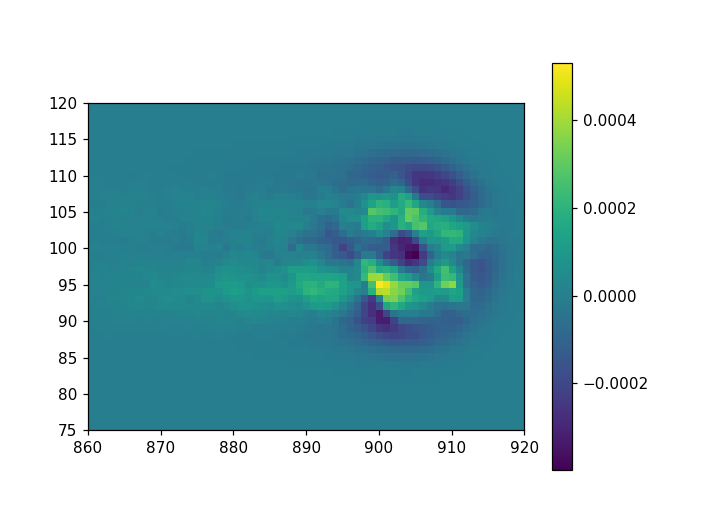

In [31]:
plt.figure()
plt.imshow(res)
plt.xlim(860,920)
plt.ylim(75,120)
plt.colorbar()
plt.show()
# out.params.valuesdict()

In [32]:
a=out.params['a'].value
b=out.params['b'].value
R=out.params['R'].value
sigma=out.params['sigma'].value
t0=out.params['t0'].value
sigmaG=out.params['sigmaG'].value
angle=out.params['angle'].value
C=out.params['C'].value

In [33]:
IC = icg.resolution(Eaxis, Ei=Ei, E0=E0, a=a, b=b, R=R, sigma=sigma, t0=t0, geom=geom)
G=gauss(Qaxis, Q0 , sigmaG)
model=np.tensordot( G, IC,axes=0)

<IPython.core.display.Javascript object>


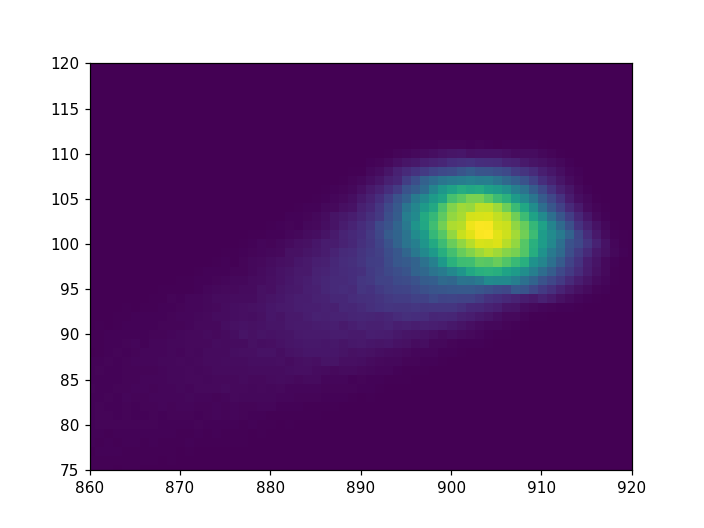

In [65]:
plt.figure('data')
plt.imshow(data)
plt.xlim(860,920)
plt.ylim(75,120)
plt.show()

<IPython.core.display.Javascript object>


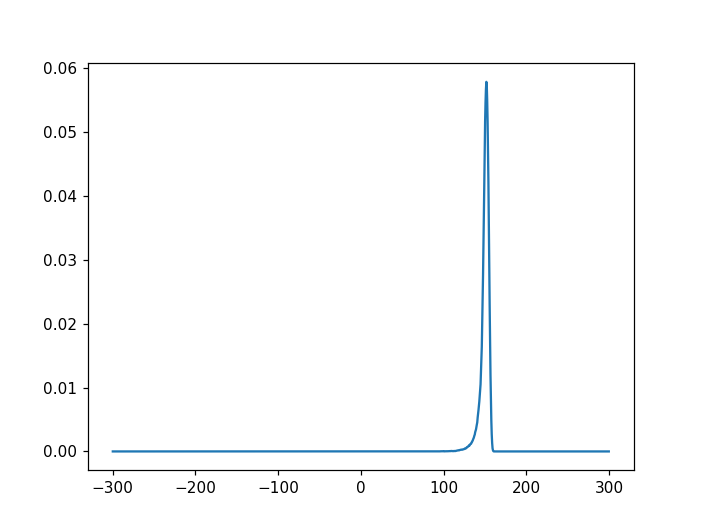

In [44]:
rS, pxS, pyS, pxyS=correlation(data)
plt.figure('E-profile of data')
plt.plot(Eaxis, pxS)
plt.show()

<IPython.core.display.Javascript object>


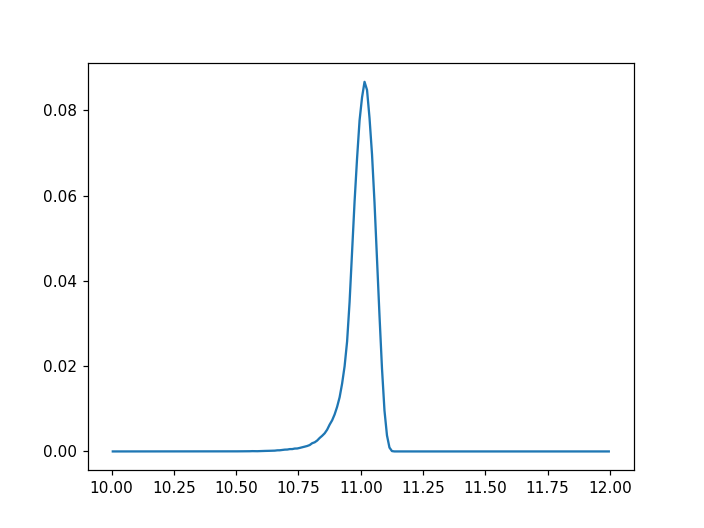

In [45]:
plt.figure('Q-profile of data')
plt.plot(Qaxis, pyS)
plt.show()

<IPython.core.display.Javascript object>


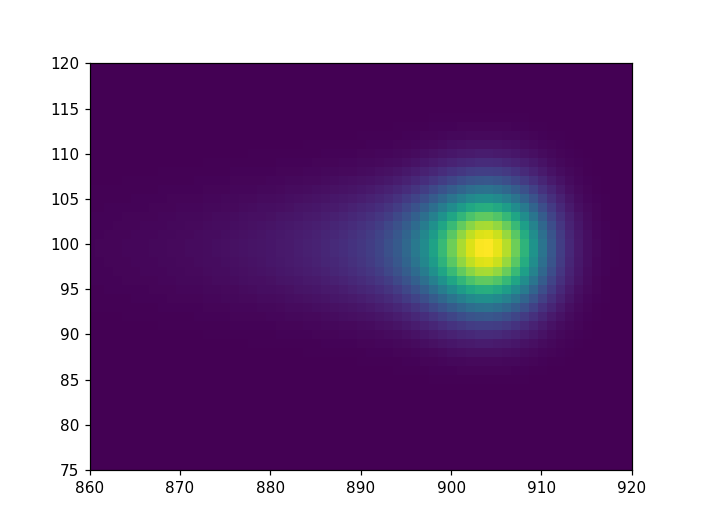

In [42]:
plt.figure('model')
plt.imshow(model)
plt.xlim(860,920)
plt.ylim(75,120)
plt.show()

<IPython.core.display.Javascript object>


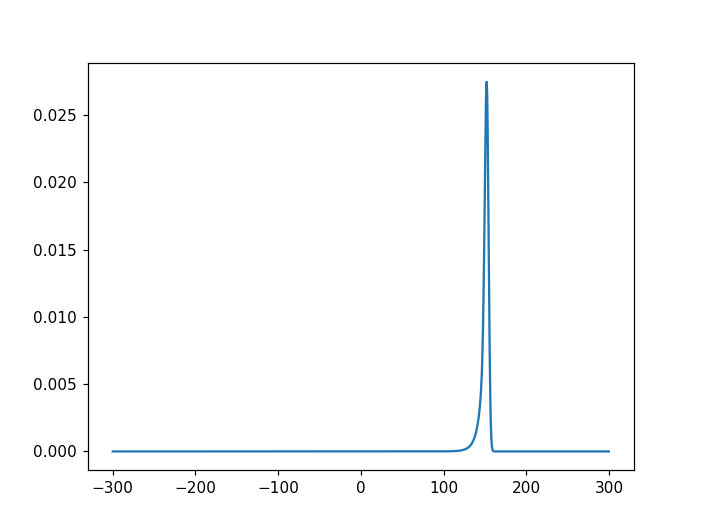

In [39]:
plt.figure('E-profile of model')
plt.plot(Eaxis,IC)
plt.show()

<IPython.core.display.Javascript object>


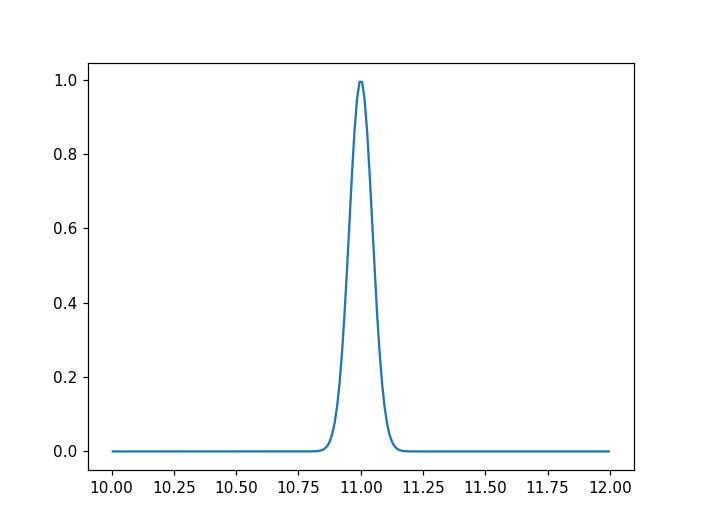

In [40]:
plt.figure('Qprofile of model')
plt.plot(Qaxis,G)
plt.show()

In [46]:
rotated=rotate(data, angle, resize=False, center=(ind_dE_center,ind_dQ_center)) ## with python code, dE, dQ
Mdata=shear_Jiao(rotated,Qaxis,Q0,C)


<IPython.core.display.Javascript object>


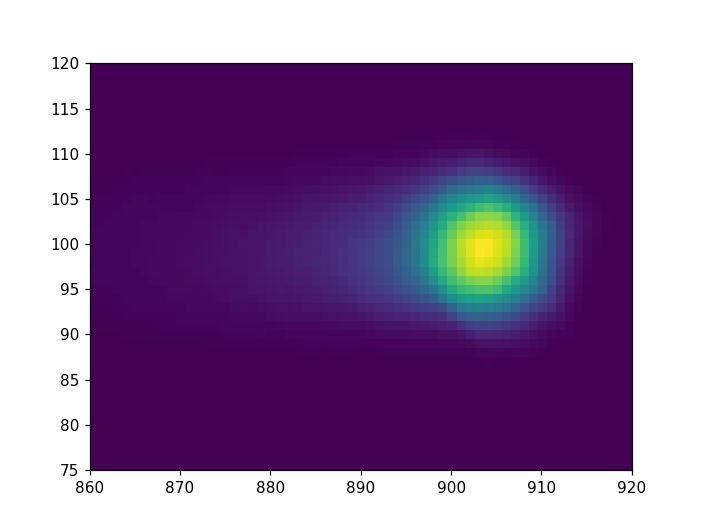

In [66]:
Mdata[Mdata!=Mdata]=0.0
plt.figure('Mdata')
plt.imshow(Mdata)
plt.xlim(860,920)
plt.ylim(75,120)
plt.show()

<IPython.core.display.Javascript object>


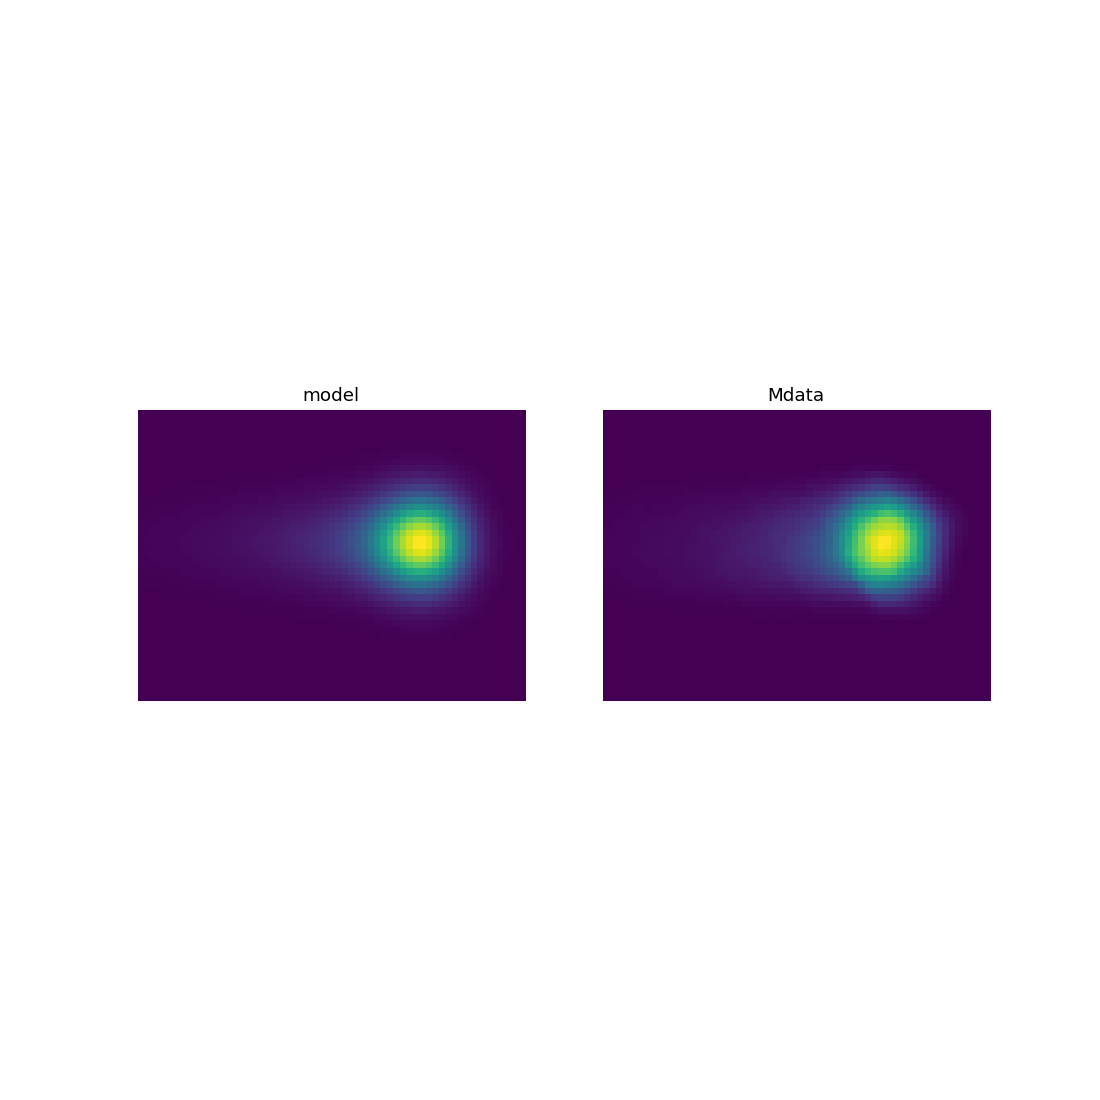

(75, 120)

In [59]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('model')
plt.imshow(model)
plt.xlim(860,920)
plt.ylim(75,120)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Mdata')
plt.imshow(Mdata)
plt.xlim(860,920)
plt.ylim(75,120)

In [60]:
Reverse=shear_Jiao(Mdata,Qaxis,Q0,-C)

In [62]:
Reverse[Reverse!=Reverse]=0.0

In [63]:
Reverse=rotate(Reverse, -angle, resize=False, center=(ind_dE_center,ind_dQ_center))

<IPython.core.display.Javascript object>


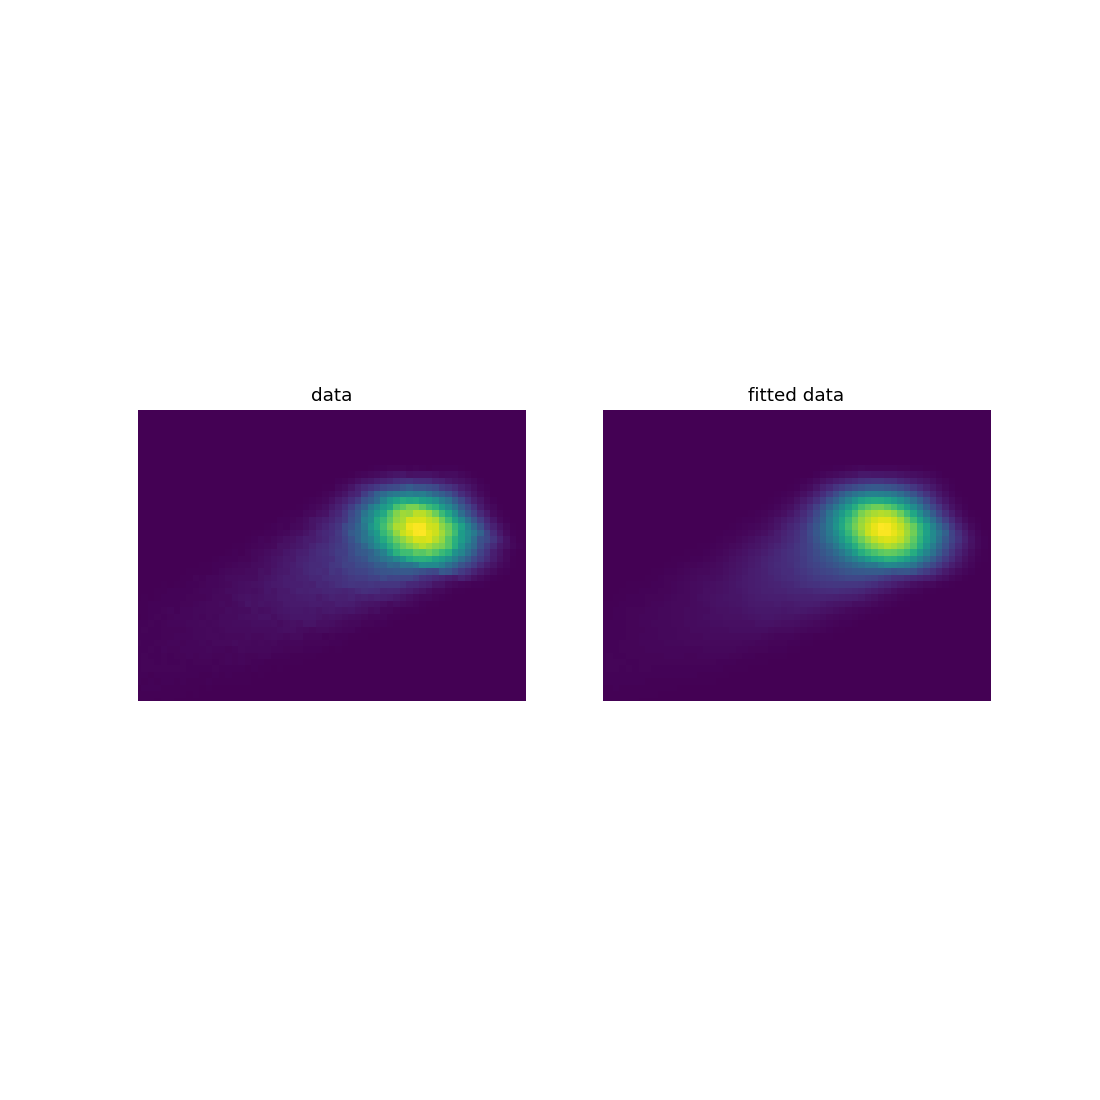

(75, 120)

In [64]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('data')
plt.imshow(data)
plt.xlim(860,920)
plt.ylim(75,120)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('fitted data')
plt.imshow(Reverse)
plt.xlim(860,920)
plt.ylim(75,120)

<IPython.core.display.Javascript object>


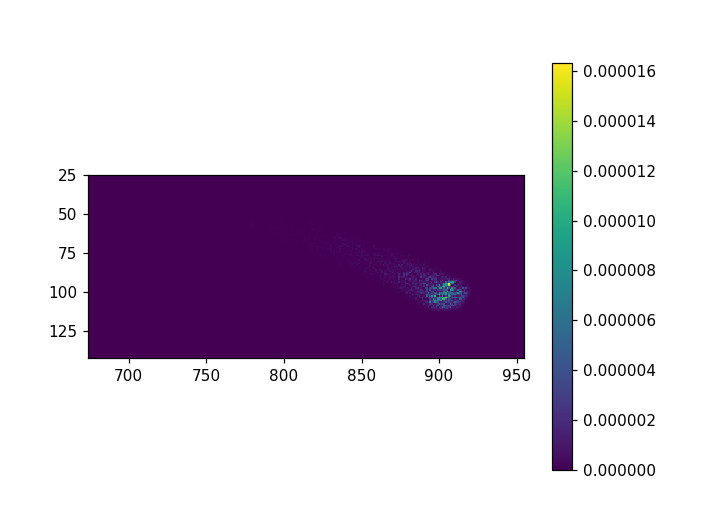

In [135]:
plt.figure()
plt.imshow(np.abs(Reverse-data))
plt.colorbar()
plt.show()